

# Dimensionality Reduction-Bitcoin Price Prediction Problem

In this case study, we will use the dimensionality reduction approach to enhance the
“bitcoin trading strategy” related case study discussed in Chapter 6. 



## 1. Problem definition

In this case study, we will use the dimensionality reduction approach to enhance the
“bitcoin trading strategy” related case study discussed in Chapter 7. 

The data and the variables used in this case study are same as the case study presented in the classification case study chapter. The data is the bitcoin data for the time
period of Jan 2012 to October 2017, with minute to minute updates of OHLC (Open,
High, Low, Close), Volume in BTC and indicated currency and weighted bitcoin
price

## 2. Loading data

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3       

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset
dataset = pd.read_csv(r'C:\Users\roosd\Downloads\econometrie jaar 3\MIF course\BitstampData_sample.csv')
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## 3. Exploratory data analysis

In [4]:
# shape
dataset.shape

(499999, 8)

In [5]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
499994,1355317560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499995,1355317620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499996,1355317680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499997,1355317740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499998,1355317800,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# describe data
set_option('display.precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,5.000e+05,24521.000,24521.000,24521.000,24521.000,24521.000,24521.000,24521.000
mean,1.340e+09,9.822,9.825,9.818,9.821,21.022,206.749,9.822
std,8.660e+06,2.666,2.667,2.665,2.666,55.478,547.135,2.666
min,1.325e+09,3.800,3.800,3.800,3.800,0.000,0.000,3.800
25%,1.333e+09,7.200,7.200,7.200,7.200,2.170,21.020,7.200
50%,1.340e+09,10.800,10.800,10.790,10.790,7.340,67.920,10.793
75%,1.348e+09,11.840,11.840,11.830,11.840,20.240,199.280,11.833
max,1.355e+09,16.410,16.410,15.490,16.000,2958.478,31212.195,16.387


## 4. Data preparation

In [7]:
#Checking for any null values and removing the null values
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

In [8]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [9]:
dataset=dataset.drop(columns=['Timestamp'])

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [10]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [11]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0


We perform feature engineering to construct technical indicators which will be used to make the predictions, and the output variable.

The current data of the bicoin consists of date, open, high, low, close and volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [12]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [13]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.379


In [14]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.379


In [15]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [16]:
dataset = dataset.dropna(axis=0)

In [17]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499965,13.34,3.9,13.34,0.0,13.351,13.356,13.386,0.075,-0.299,0.01,...,44.067,11.111,11.111,11.111,11.111,10.0,10.0,13.362,13.345,13.388
499966,13.34,3.9,13.34,0.0,13.349,13.355,13.386,0.075,-0.224,0.01,...,44.067,11.111,11.111,11.111,11.111,10.0,10.0,13.363,13.343,13.387
499967,13.34,3.9,13.34,0.0,13.348,13.354,13.385,-0.596,-0.075,0.01,...,44.067,0.000,7.407,11.111,11.111,10.0,10.0,13.364,13.342,13.387
499968,13.34,3.9,13.34,0.0,13.346,13.353,13.385,-0.596,0.000,-0.08,...,44.067,0.000,3.704,11.111,11.111,10.0,10.0,13.356,13.342,13.387
499969,13.34,3.9,13.34,0.0,13.345,13.352,13.385,-0.596,0.075,-0.08,...,44.067,0.000,0.000,11.111,11.111,10.0,10.0,13.348,13.342,13.387


Data visualization

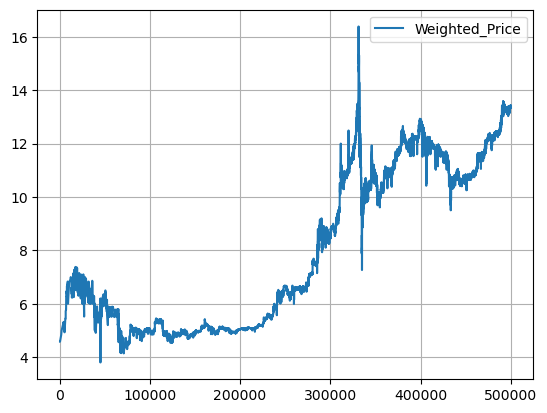

In [18]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

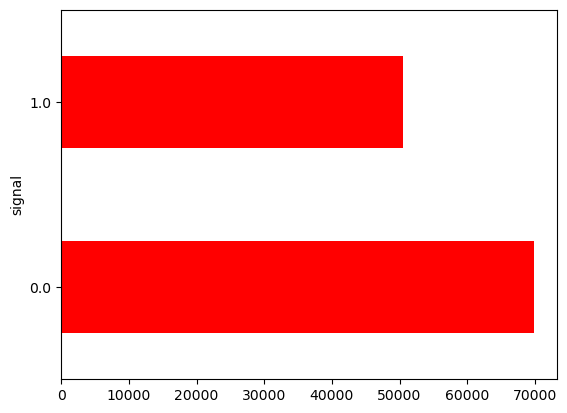

In [19]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

## 5. Evaluate algorithms and models

We split the dataset into 80% training set and 20% test set.

In [20]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-10000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

### Data Standardisation
As a preprocessing step, let's start with normalizing the feature values so they standardised - this makes comparisons simpler and allows next steps for Singular Value Decomposition.

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,Close,Volume_(BTC),Weighted_Price,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
476354,-0.259,-0.141,-0.270,-0.261,-0.270,-0.320,0.094,0.096,0.098,0.099,...,1.177,0.896,0.931,0.927,0.957,0.992,1.011,-0.260,-0.270,-0.326
484333,-0.259,-0.307,-0.262,-0.272,-0.306,-0.289,0.577,0.494,0.568,0.490,...,-0.105,0.896,0.931,0.927,0.957,0.268,0.277,-0.266,-0.318,-0.281


### Singular Value Decomposition-(Feature Reduction)
We want to reduce the dimensionality of the problem to make it more manageable, but at the same time we want to preserve as much information as possible. 

Hence, we use a technique called singu‐
lar value decomposition (SVD), which is one of the ways of performing PCA.Singular Value Decomposition (SVD) is a matrix factorization commonly used in signal processing and data compression. We are using the TruncatedSVD method in the sklearn package.

Variance preserved by first 5 components == 94.24%


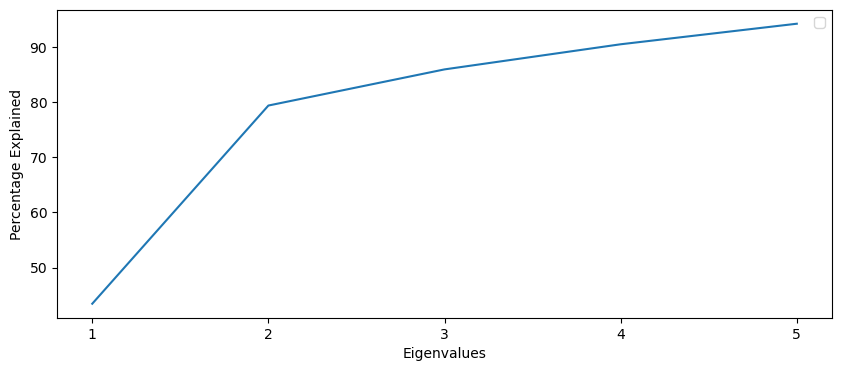

In [22]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

We can preserve 94.24% variance by using just 5 components rather than the full 25+ original features.

In [23]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(8000, 5)


,c0,c1,c2,c3,c4
476354,2.675,-1.342,-1.344,0.339,-0.006
484333,2.332,-1.303,0.072,0.233,-0.648
476100,0.276,-1.362,0.390,0.266,-1.067
478974,1.541,-2.815,-0.924,0.189,-0.556
491284,3.786,2.950,-0.024,1.770,1.226


Lets attempt to visualise the data with the compressed dataset, represented by the top 5 components of an SVD.

In [24]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

### Pairs Plots
Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (or type of signal).

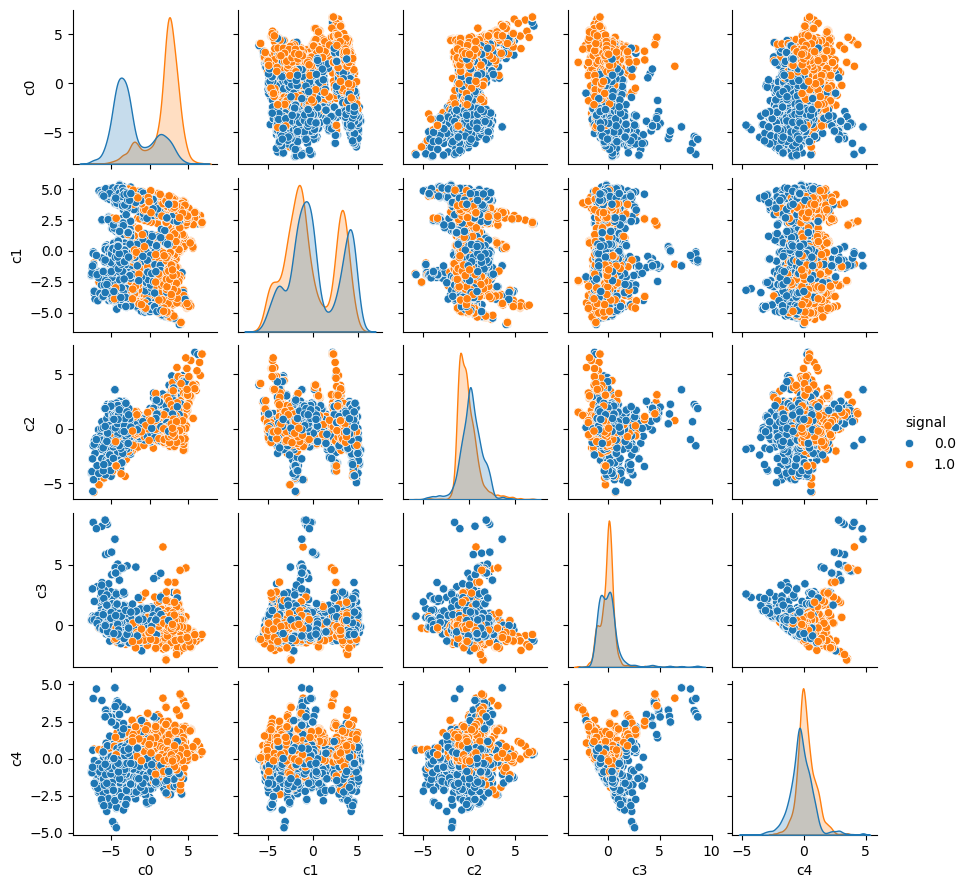

In [25]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)

__Observation__:

* In the scatter plot of each of the principal component, we can clearly that there is
a clear segregation of the orange and blue dots, which means that data-points
from the same type of signal tend to cluster together.

* However, it’s hard to get a full appreciation of the differences and similarities
between data points across all the components, requiring that the reader hold
comparisons in their head while viewing

### 3D Scatterplot
As an alternative to the pairs-plots, we could view a 3D scatterplot, which at least lets us see more dimensions at once and possibly get an interactive feel for the data

In [30]:
def scatter_3D(A, elevation=30, azimuth=120):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assuming columns are PC1, PC2, PC3, signal
    scatter = ax.scatter(A.iloc[:, 0], A.iloc[:, 1], A.iloc[:, 2], 
                        c=A['signal'], cmap='viridis', s=50)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(elev=elevation, azim=azimuth)
    plt.colorbar(scatter)
    plt.show()

In [31]:
from ipywidgets import interactive, fixed
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dfsvd['signal'] = Y_train
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

__Observation__:

The iPython Notebook interactive package lets us create an interactive plot with controls for elevation and azimuth
We can use these controls to interactively change the view of the top 3 components and investigate their relations. This certainly appears to be more informative than pairs-plots.

However, we still suffer from the same major limitations of the pairs-plots, namely that we lose a lot of the variance and have to hold a lot in our heads when viewing.

### t-SNE visualization

In this step, we implement another technique of dimensionality reduction; t-SNE and look at the related visualization. We will use the basic implementation available in scikit-learn

In [32]:
tsne = TSNE(n_components=2, random_state=0)

Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

dftsne['signal'] = Y_train

Text(0.5, 1.0, 'Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

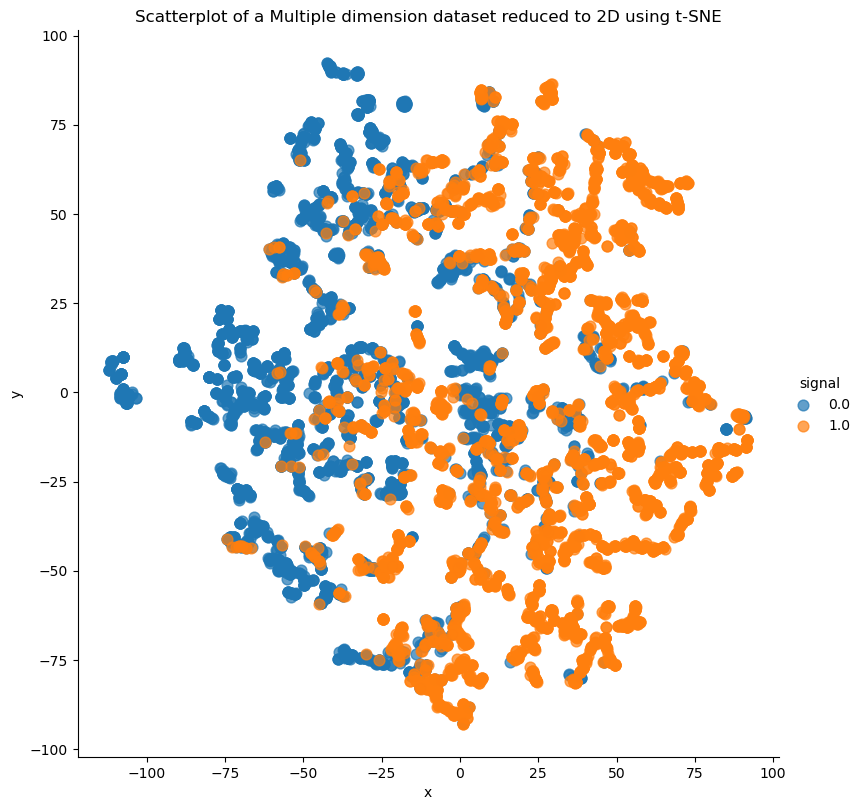

In [35]:
g = sns.lmplot(x='x', y='y', data=dftsne, hue='signal', fit_reg=False, 
               height=8, scatter_kws={'alpha':0.7, 's':60})
g.axes.flat[0].set_title('Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

__Observation__:

This is quite interesting way of visualizing the trading signal data. The above plot shows us that there is a good degree of clustering for the trading signal. Although, there are some overap of the long and short signals, but they can be distinguished quite well using the reduced number of features. 



__In Review__:

We have analyzed the bitcoin trading signal dataset in the following steps:

* We prepared the data by cleaning (removing character features values, replacing nans) and normalizing.
* We applied transformation during the feature reduction stage.
* We then visualized the data in the reduced dimentionality and ultimately applied t-SNE algorithm to reduce the data into two dimensions and visualize effectivly

### Compare models with and without dim reduction

In [36]:
# test options for classification
scoring = 'accuracy'
seed = 7
kfold = 10

In [37]:
import time
start_time = time.time()

In [38]:
# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 16.278591871261597 seconds ---


In [39]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 9.154920101165771 seconds ---


In [40]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.959125 (0.005647)
Result with dimensionality Reduction: 0.931000 (0.008020)


Looking at the model results, we do not deviate that much from the accuracy, and the
accuracy just decreases from 95.9% to 93.1%. However, there is almost a 2 time improvement in the time taken, which is significant.

__Conclusion__:


With dimensionality reduction, we achieved almost the same accuracy with two times improvement in the time. In trading strategy development, when the datasets are huge and the number of features
is big such improvement in time can lead to a significant improvement in the entire
process. 

We demonstrated that both SVD and t-SNE provide quite interesting way of visualizing the trading signal data, and provide a way to distinguished long and short signals
of a trading strategy with reduced number of features.
